In [74]:
###########################################################################
# Coded by Florentin Millour, and translated in Python by Jules Scigliuto #
###########################################################################


import numpy as np
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
import os
from astropy.io import fits

def simuInterf():
    """
    Simulation tools for interferometric arrays.

    Returns:
        version (str): Version of the simulation tool.
    """
    version = "$Revision: 627 $".split(":")[1].strip(" $")
    if callable(simuInterf):
        print("Usage: simuInterf")
    return version

###########################################################################

def simi_get_kwd_vals(file_name, keywords):
    """
    Extract values of specified keywords from a FITS file.

    Parameters:
        file_name (str): Path to the FITS file.
        keywords (list): List of keywords to extract.

    Returns:
        list: List of values corresponding to the keywords.
    """
    try:
        # Open the FITS file
        with fits.open(file_name) as hdul:
            header = hdul[0].header  # Access the primary header
            # print(header)

        # Extract values for the provided keywords
        values = [header.get(keyword, "-") for keyword in keywords]
        return values

    except FileNotFoundError:
        print(f"File not found: {file_name}")
        return ["-"] * len(keywords)

    except Exception as e:
        print(f"Error reading FITS file: {e}")
        return ["-"] * len(keywords)

###########################################################################

def simiGenerateUV(stardata, stations, lst, coloring, usedStations, 
                   hacen=None, harange=None, hastep=None, lambda_=None, colors=None, 
                   mx=None, fp=None, frac=None, msize=None, marker=None, 
                   spFreqFact=None, xyTitles=None, place=None, interferometer=None):
    """
    Generate UV coordinates for interferometric simulations.

    Parameters:
        stardata (dict): Star data with properties like RA, Dec, etc.
        stations (ndarray): Station positions.
        lst (list): Local Sidereal Times (to be filled).
        coloring (list): Colors for visualization (to be filled).
        usedStations (list): Used station data (to be filled).
        hacen (float): Hour angle center.
        harange (float): Hour angle range.
        hastep (float): Hour angle step.
        lambda_ (ndarray): Wavelengths.
        colors (str): Coloring mode ("wlen", "bases", etc.).
        mx, fp, frac, msize, marker, spFreqFact, xyTitles (various): Other parameters.
        place (str): Observation site.
        interferometer (str): Interferometer name.

    Returns:
        uvwTable (ndarray): UVW coordinates.
    """
    if place is None:
        place = "paranal"
    if interferometer is None:
        interferometer = "VLTI"
    
    # Placeholder for simiGetLocation - replace with actual implementation
    loc = simiGetLocation(place, interferometer)

    if lambda_ is None:
        n_lambda = 20
        lambda_min = 1.1 * 1e-6  # Conversion for micro to meters
        lambda_max = 2.5 * 1e-6
        lambda_ = np.linspace(lambda_max, lambda_min, n_lambda)
    else:
        n_lambda = len(lambda_)

    if colors is None:
        colors = "wlen"

    if spFreqFact is None:
        spFreqFact = 1.0

    if xyTitles is None:
        xyTitles = [
            "E <------ Spatial frequency (m^-1^)",
            "Spatial frequency (m^-1^) ------> N"
        ]

    if frac is None:
        frac = 1.0

    if msize is None:
        msize = 1.0

    if marker is None:
        marker = '\1'

    if hacen is None:
        hacen = stardata.get("ra", 0)
    if harange is None:
        harange = 8.0

    hamin = hacen - harange / 2
    hamax = hacen + harange / 2

    if hastep is None:
        hastep = 70.0 / 60.0

    n_obs = stations.shape[1] if stations.ndim > 1 else 1

    uvwTable = np.empty((0, 3))
    lst.clear()
    coloring.clear()
    usedStations.clear()

    for k_obs in range(n_obs):
        nb_tel = stations.shape[0]
        nb_bases = nb_tel * (nb_tel - 1) // 2

        baseNames = []
        B = []
        orig = []

        for i_obs in np.arange(hamin, hamax + hastep, hastep):
            stardata["lst"] = float(i_obs) + hastep / 2.0 * frac * random.uniform(0, 1)
            lst.append(stardata["lst"])

            for i_base in range(nb_bases):
                # Compute base vectors (placeholder for simiComputeBaseVect)
                bvect = B[i_base] if i_base < len(B) else np.zeros(3)
                stardata.update(simiComputeUvwCoord(stardata, bvect))

                uv = np.array([stardata["u"], stardata["v"]])
                uvw = np.array([stardata["u"], stardata["v"], stardata["w"]])

                uvwTable = np.vstack((uvwTable, uvw))

    return uvwTable

###########################################################################

def getColVal(color):
    """
    Returns RGB values for a given color name or generates random RGB values.

    Parameters:
        color (str): Name of the color (e.g., "red", "green", "blue").

    Returns:
        list: RGB values as a list of integers [R, G, B].
    """
    color_map = {
        "red": [255, 0, 0],
        "green": [0, 255, 0],
        "blue": [0, 0, 255],
        "cyan": [0, 255, 255],
        "magenta": [255, 0, 255],
        "yellow": [255, 255, 0],
        "black": [0, 0, 0],
        "white": [255, 255, 255],
    }
    
    if color in color_map:
        return color_map[color]
    else:
        # Generate random RGB values
        return np.random.randint(0, 256, size=3).tolist()

###########################################################################

def simiPlotUV(stardata, stations, lst, coloring, usedStations, 
               hacen=None, harange=None, hastep=None, lambda_vals=None, 
               colors=None, mx=None, fp=None, frac=None, msize=None, 
               marker=None, spFreqFact=None, xyTitles=None, place=None, 
               interferometer=None):
    """
    Simulates and plots UV coverage for an interferometric array.

    Parameters:
        stardata (dict): Input star structure.
        stations (list): Input stations.
        lst (list): (output) Local sidereal time.
        coloring (list): (output) Colors for each base/observation/point.
        usedStations (list): (output) Used stations.
        hacen (float): Hour angle center.
        harange (float): Hour angle range.
        hastep (float): Hour angle step.
        lambda_vals (list): Wavelengths.
        colors (str): Colors option.
        mx (float): Plot limits.
        fp (int): Full plot mode.
        frac (float): Fractional step.
        msize (float): Marker size.
        marker (str): Marker style.
        spFreqFact (float): Spatial frequency factor.
        xyTitles (list): Titles for X and Y axes.
        place (str): Location.
        interferometer (str): Interferometer name.

    Returns:
        np.ndarray: UV coverage table.
    """
    if spFreqFact is None:
        spFreqFact = 1.0

    if lambda_vals is None:
        nLambda = 20
        lambda_min = 1.1e-6
        lambda_max = 2.5e-6
        lambda_vals = np.linspace(lambda_max, lambda_min, nLambda)
    else:
        nLambda = len(lambda_vals)

    if xyTitles is None:
        xyTitles = ["E <------ Spatial frequency (m^-1^)",
                    "Spatial frequency (m^-1^) ------> N"]

    if msize is None:
        msize = 1.0

    if marker is None:
        marker = 'o'

    stations = np.array(stations)
    dimz = stations.shape
    nObs = 1 if dimz[1] == 1 else dimz[0]

    if mx is None:
        mx = 0

    uvTable = simiGenerateUV(stardata, stations, lst, coloring, usedStations,
                             hacen=hacen, harange=harange, hastep=hastep, 
                             lambda_vals=lambda_vals, colors=colors, mx=mx, 
                             fp=fp, frac=frac, msize=msize, marker=marker, 
                             spFreqFact=spFreqFact, xyTitles=xyTitles, 
                             place=place, interferometer=interferometer)

    nHa = uvTable.shape[3]

    plt.figure(figsize=(8, 8))
    for kObs in range(nObs):
        nbTel = len(stations[:, kObs])
        nbBases = nbTel * (nbTel - 1) // 2

        for iObs in range(nHa):
            for iBase in range(nbBases):
                u = uvTable[0, :, iObs, kObs]
                v = uvTable[1, :, iObs, kObs]

                for iP in range(nLambda):
                    kolor = coloring[:, iP, iBase, iObs, kObs]

                    v_spfreq = v[iBase] / lambda_vals[iP]
                    u_spfreq = u[iBase] / lambda_vals[iP]

                    if fp == 1:
                        param = np.linspace(-np.pi, np.pi, 30)
                        diam = 1.8 if iBase not in [0, 2] else 8.0

                        plt.plot(spFreqFact * (diam / 2 / lambda_vals[iP] * np.cos(param) + v_spfreq),
                                 spFreqFact * (diam / 2 / lambda_vals[iP] * np.sin(param) + u_spfreq),
                                 color=kolor, linestyle='-', marker=None)

                        plt.plot(spFreqFact * (diam / 2 / lambda_vals[iP] * np.cos(param) - v_spfreq),
                                 spFreqFact * (diam / 2 / lambda_vals[iP] * np.sin(param) - u_spfreq),
                                 color=kolor, linestyle='-', marker=None)
                    else:
                        plt.scatter(spFreqFact * v_spfreq, spFreqFact * u_spfreq, color=kolor, s=msize)
                        plt.scatter(spFreqFact * -v_spfreq, spFreqFact * -u_spfreq, color=kolor, s=msize)

        tmax = spFreqFact * np.max((v + 8.0 / 2) / np.min(lambda_vals))
        tmin = spFreqFact * np.min((v - 8.0 / 2) / np.max(lambda_vals))

        mx = max(mx, abs(tmax), abs(tmin))

    plt.xlim(-mx, mx)
    plt.ylim(-mx, mx)
    plt.xlabel(xyTitles[0])
    plt.ylabel(xyTitles[1])
    plt.grid(True)
    plt.show()

    return uvTable

###########################################################################

@dataclass
class SimiSTARVIS:
    date: str
    u: float
    v: float
    w: float
    ra: float
    dec: float
    lst: float
    ha: float
    theta: float
    base: float
    delay: float

###########################################################################

@dataclass
class SimiLOCATION:
    name: str
    tz: float
    dst: float
    lon: float
    lat: float
    elev: float

###########################################################################

def simiGetLocation(place, interferometer=None):
    """
    Fills in the SimiLOCATION structure based on the input place and interferometer.

    Parameters:
        place (str): The location (e.g., "paranal", "e-elti", "MWI", "calern").
        interferometer (str, optional): The interferometer (e.g., "VLTI", "CHARA").

    Returns:
        SimiLOCATION: A structure with the location's details.
    
    Raises:
        ValueError: If the place is not recognized.
    """
    loc = SimiLOCATION(name="", tz=0, dst=0, lon=0, lat=0, elev=0)
    
    if place.lower() == "paranal":
        if interferometer is None:
            interferometer = "VLTI"
        loc.name = "ESO, Cerro Paranal"
        loc.tz = 4
        loc.dst = -1
        loc.lon = -4.69365
        loc.lat = -24.62794830
        loc.elev = 2635
        _simiSaveStations(interferometer)
    elif place.lower() == "e-elti":
        loc.name = "ESO, Cerro Armazones"
        loc.tz = 4
        loc.dst = -1
        loc.lon = -4.69365
        loc.lat = -24.62794830
        loc.elev = 3003
        _simiSaveStations(interferometer)
    elif place.lower() == "mwi":
        if interferometer is None:
            interferometer = "CHARA"
        loc.name = "Mount Wilson"
        loc.tz = 4
        loc.dst = -1
        loc.lon = -118.061644
        loc.lat = 34.223758
        loc.elev = 1742
        _simiSaveStations(interferometer)
    elif place.lower() == "calern":
        if interferometer is None:
            interferometer = "GI2T"
        loc.name = "Calern Observatory"
        loc.tz = 1
        loc.dst = 0
        loc.lon = 6.92098
        loc.lat = 43.75389
        loc.elev = 1270
        _simiSaveStations(interferometer)
    else:
        raise ValueError("Place not found!")

    # Logging output for testing
    print(f"You are here: {loc.name}")
    return loc

def _simiSaveStations(interferometer):
    """
    Simulates saving station details for the given interferometer.

    Parameters:
        interferometer (str): The interferometer name.
    """
    # Placeholder for actual station-saving logic.
    print(f"Saving stations for {interferometer}...")

###########################################################################

def simiComputeUvwCoord(data, bvect, loc):
    """
    Corrects UVW coordinates using the base vector of an observation and updates the data fields.

    Parameters:
        data (dict): Dictionary containing the `simiSTARVIS` structure to be corrected.
        bvect (list): Base vector of observation [x, y, z].
        loc (dict): Location structure containing latitude.

    Modifies:
        Updates `data` with corrected UVW values, baseline, theta, and delay.
    """
    degr = 180 / math.pi
    hour = degr / 15.0
    Bnorm = math.sqrt(sum([x**2 for x in bvect]))
    print('loc:', loc)

    # Baseline vector in alt-az coordinates
    Balt = math.asin(bvect[2] / (Bnorm + (Bnorm == 0))) * degr
    Baz = math.atan2(bvect[1], bvect[0]) * degr
    print('loc lat:', loc.lat)
    
    # Baseline vector in equatorial coordinates
    Bdec = math.asin(
        math.sin(Balt / degr) * math.sin(loc.lat / degr) +
        math.cos(Balt / degr) * math.cos(loc.lat / degr) * math.cos(Baz / degr)
    ) * degr

    yBha = (math.sin(Balt / degr) * math.cos(loc.lat / degr) -
            math.cos(Balt / degr) * math.cos(Baz / degr) * math.sin(loc.lat / degr))
    zBha = -1.0 * math.cos(Balt / degr) * math.sin(Baz / degr)
    Bha = (math.atan2(zBha, yBha) * hour + 24) % 24

    # Baseline vector in equatorial cartesian frame
    Lx = -(-Bnorm * math.cos(Bdec / degr) * math.cos(Bha / hour))
    Ly = -Bnorm * math.cos(Bdec / degr) * math.sin(Bha / hour)
    Lz = Bnorm * math.sin(Bdec / degr)

    # Projection of the baseline vector on the u, v, w frame
    data['ha'] = data['lst'] - data['ra']
    data['u'] = (math.sin(data['ha'] / hour) * Lx + math.cos(data['ha'] / hour) * Ly)
    data['v'] = (-math.sin(data['dec'] / degr) * math.cos(data['ha'] / hour) * Lx +
                 math.sin(data['dec'] / degr) * math.sin(data['ha'] / hour) * Ly +
                 math.cos(data['dec'] / degr) * Lz)
    data['w'] = (math.cos(data['dec'] / degr) * math.cos(data['ha'] / hour) * Lx -
                 math.cos(data['dec'] / degr) * math.sin(data['ha'] / hour) * Ly +
                 math.sin(data['dec'] / degr) * Lz)

    data['theta'] = math.atan2(data['u'], data['v']) * degr
    data['base'] = math.sqrt(data['u']**2 + data['v']**2)
    data['delay'] = -data['w']

    return data

###########################################################################

def simiGetNonRedundantStations(stations_file=None, nb_tels=2):
    """
    Identifies non-redundant stations from a given file.

    Parameters:
        stations_file (str, optional): Path to the stations file. Defaults to "~/.interfStations.dat".
        nb_tels (int, optional): Number of telescopes (2 or 3). Defaults to 2.

    Returns:
        list: List of non-redundant station combinations.
    """
    if stations_file is None:
        stations_file = "~/.interfStations.dat"

    # Simulated file reading (replace with actual file parsing)
    data = {
        "stats": ["A", "B", "C", "D"],  # Example station names
        "SE": [0.0, 10.0, 20.0, 30.0],  # East coordinates
        "SN": [0.0, 5.0, 15.0, 25.0],   # North coordinates
        "SZ": [0.0, 2.0, 4.0, 6.0],     # Height coordinates
        "diam": [1.5, 1.5, 1.5, 1.5]    # Telescope diameters
    }

    stats = data["stats"]
    SE, SN, SZ, diam = data["SE"], data["SN"], data["SZ"], data["diam"]
    n_stat = len(stats)
    non_redundant = []

    if nb_tels == 2:
        for k in range(n_stat):
            for l in range(k + 1, n_stat):
                be = SE[l] - SE[k]
                bn = SN[l] - SN[k]
                bz = SZ[l] - SZ[k]
                blen = math.sqrt(be**2 + bn**2 + bz**2)
                basdif = abs(be - bn)
                if basdif > (sum(diam) / 2):
                    non_redundant.append((stats[k], stats[l]))
    elif nb_tels == 3:
        for k in range(n_stat):
            for l in range(k + 1, n_stat):
                for m in range(l + 1, n_stat):
                    non_redundant.append((stats[k], stats[l], stats[m]))
    else:
        raise ValueError("Unsupported number of telescopes!")

    return non_redundant

###########################################################################


def simi_save_stations(interferometer, stations_file=None):
    """
    Saves a table containing the station coordinates in observatory
    coordinates (P & Q) and in E-W, N-S coordinates (meters).

    Parameters:
        interferometer (str): Name of the interferometer.
        stations_file (str, optional): File name to save the station information.

    Returns:
        list: List of station names.
    """
    if stations_file is None:
        stations_file = "~/.interfStations.dat"

    positions = ""

    if interferometer == "VLTI":
        positions = (
            " ID P Q E N ALT D C\n"
            "A0 -32.001 -48.013 -14.642 -55.812 0.0 1.8 1\n"
            "A1 -32.001 -64.021 -9.434 -70.949 0.0 1.8 2\n"
            "B0 -23.991 -48.019 -7.065 -53.212 0.0 1.8 3\n"
            "B1 -23.991 -64.011 -1.863 -68.334 0.0 1.8 4\n"
            "B2 -23.991 -72.011 0.739 -75.899 0.0 1.8 5\n"
            "B3 -23.991 -80.029 3.348 -83.481 0.0 1.8 6\n"
            "B4 -23.991 -88.013 5.945 -91.030 0.0 1.8 7\n"
            "B5 -23.991 -96.012 8.547 -98.594 0.0 1.8 8\n"
            "C0 -16.002 -48.013 0.487 -50.607 0.0 1.8 9\n"
            "C1 -16.002 -64.011 5.691 -65.735 0.0 1.8 10\n"
            "C2 -16.002 -72.019 8.296 -73.307 0.0 1.8 11\n"
            "C3 -16.002 -80.010 10.896 -80.864 0.0 1.8 12\n"
            "D0 0.010 -48.012 15.628 -45.397 0.0 1.8 13\n"
            "D1 0.010 -80.015 26.039 -75.660 0.0 1.8 14\n"
            "D2 0.010 -96.012 31.243 -90.787 0.0 1.8 15\n"
            "E0 16.011 -48.016 30.760 -40.196 0.0 1.8 16\n"
            "G0 32.017 -48.0172 45.896 -34.990 0.0 1.8 17\n"
            "G1 32.020 -112.010 66.716 -95.501 0.0 1.8 18\n"
            "G2 31.995 -24.003 38.063 -12.289 0.0 1.8 19\n"
            "H0 64.015 -48.007 76.150 -24.572 0.0 1.8 20\n"
            "I1 72.001 -87.997 96.711 -59.789 0.0 1.8 21\n"
            "J1 88.016 -71.992 106.648 -39.444 0.0 1.8 22\n"
            "J2 88.016 -96.005 114.460 -62.151 0.0 1.8 23\n"
            "J3 88.016 7.996 80.628 36.193 0.0 1.8 24\n"
            "J4 88.016 23.993 75.424 51.320 0.0 1.8 25\n"
            "J5 88.016 47.987 67.618 74.009 0.0 1.8 26\n"
            "J6 88.016 71.990 59.810 96.706 0.0 1.8 27\n"
            "K0 96.002 -48.006 106.397 -14.165 0.0 1.8 28\n"
            "L0 104.021 -47.998 113.977 -11.549 0.0 1.8 29\n"
            "M0 112.013 -48.000 121.535 -8.951 0.0 1.8 30\n"
            "U1 -16.000 -16.000 -9.925 -20.335 8.504 8 31\n"
            "U2 24.000 24.000 14.887 30.502 8.504 8 32\n"
            "U3 64.0013 47.9725 44.915 66.183 8.504 8 33\n"
            "U4 112.000 8.000 103.306 43.999 8.504 8 34\n"
            "LAB 52.000 -40.000 60 -20 0.0"
        )

    elif interferometer == "NACO_SAM_7":
        mask_positions = [
            [3.51064, -1.99373],
            [3.51064, 2.49014],
            [1.56907, 1.36918],
            [1.56907, 3.61111],
            [-0.372507, -4.23566],
            [-2.31408, 3.61111],
            [-4.25565, 0.248215]
        ]
        mask_diameter = 1.50
        positions = " ID P Q E N ALT D C\n"
        for i, (x, y) in enumerate(mask_positions, 1):
            positions += f"H{i} {x:.3f} {y:.3f} {x:.3f} {y:.3f} 0.0 {mask_diameter:.1f} 1\n"
        positions += "LAB 0.0 0.0 0.0 0.0 0.0 0.0 1"

    elif interferometer == "CHARA":
        positions = (
            " ID P Q E N ALT D C\n"
            "S1 0.0 0.0 0.0 0.0 0.0 1.0 1\n"
            "S2 0.0 0.0 -5.748 33.577 0.637 1.0 2\n"
            "E1 0.0 0.0 125.333 305.928 -5.919 1.0 3\n"
            "E2 0.0 0.0 70.389 269.715 -2.803 1.0 4\n"
            "W1 0.0 0.0 -175.068 216.327 -10.798 1.0 5\n"
            "W2 0.0 0.0 -69.085 199.342 0.471 1.0 6\n"
            "LAB 0.0 0.0 -20.0 200 0.0 0.0 7"
        )

    elif interferometer == "calern":
        positions = (
            " ID P Q E N ALT D C\n"
            "M1 0.0 0.0 0.0 0.0 0.0 1.5 1\n"
            "G1 0.0 0.0 -151 -157 0.0 1.5 2\n"
            "G2 0.0 0.0 -151 -141.5 0.0 1.5 3\n"
            "G1b 0.0 0.0 -151 -181.5 0.0 1.5 4\n"
            "G2b 0.0 0.0 -151 -109.5 0.0 1.5 5\n"
            "C1 0.0 0.0 146 -103 0.0 1.0 6\n"
            "C2 0.0 0.0 167 -103 0.0 1.0 7\n"
            "S1 0.0 0.0 -12 -401.5 0.0 1.5 8"
        )

    elif interferometer == "e-elti":
        D = 42  # ELT diameter
        D2 = 11.76  # ELT central obscuration diameter
        d = 1.47 * np.cos(np.pi / 6)  # Telescope spacing
        nm = int(D / d * np.sqrt(2)) + 1

        positions = " ID P Q E N ALT D C\n"
        count = 0
        for k in range(-nm // 2, nm // 2 + 1):
            for l in range(-nm // 2, nm // 2 + 1):
                y = k * d + 0.5 * d * (l % 2) + 0.5 * d
                x = (l - 1) * d * np.sin(np.pi / 3)
                r = np.sqrt(x**2 + y**2)
                if D2 / 2 + d / 2 < r < D / 2 - d / 2:
                    count += 1
                    positions += f"O{count} {x:.3f} {y:.3f} {x:.3f} {y:.3f} 0.0 {d:.3f} 1\n"
    else:
        raise ValueError("Interferometer not found!")

    # Save the station data to the file
    with open(stations_file, "w") as fh:
        fh.write(positions)

    print(f"Station data saved to {stations_file}")

###########################################################################

def simi_get_base_vect(station1, station2, orig=None, fix_delay=None, stations_file=None):
    """
    Gets the geographical coordinates based on stations.

    Parameters:
        station1 (str): First station for the considered baseline.
        station2 (str): Second station for the considered baseline.
        orig (list, optional): Geographical origin coordinates (output).
        fix_delay (float, optional): Fixed delay (output).
        stations_file (str, optional): Path to the stations file. Defaults to '~/.interfStations.dat'.

    Returns:
        list: Baseline vector [North, East, Altitude difference].
    """
    if stations_file is None:
        stations_file = os.path.expanduser("~/.interfStations.dat")

    if not os.path.exists(stations_file):
        raise FileNotFoundError("Please use simi_get_location to generate the stations file first.")

    # Read the stations file
    with open(stations_file, "r") as fh:
        data = [line.strip().split() for line in fh.readlines()]
    
    # Initialize variables
    bp1 = bq1 = be1 = bn1 = bz1 = None
    bp2 = bq2 = be2 = bn2 = bz2 = None
    labp = labq = labe = labn = labz = None

    # Parse station data
    for entry in data[1:]:  # Skip header line
        if entry[0] == station1:
            print('entrée1:', entry[0])
            bp1, bq1, be1, bn1, bz1 = map(float, entry[1:6])
            orig = [be1, bn1, bz1]
        elif entry[0] == station2:
            print('entrée2:', entry[0])
            bp2, bq2, be2, bn2, bz2 = map(float, entry[1:6])
        elif entry[0] == "LAB":
            labp, labq, labe, labn, labz = map(float, entry[1:6])

    if labp is not None and bp1 is not None and bp2 is not None:
        # Compute fixed delays
        dl1 = abs(bq1 - labq) + abs(bp1 - labp)
        dl2 = abs(bq2 - labq) + abs(bp2 - labp)
        fix_delay = dl2 - dl1
        print(f"{station1}: {dl1}, {station2}: {dl2}, Fixed delay: {fix_delay}")

    # Log test output
    if be1 is not None and be2 is not None and bn1 is not None and bn2 is not None:
        base_length = np.sqrt((be2 - be1) ** 2 + (bn2 - bn1) ** 2)
        base_angle = np.degrees(np.arctan2(bn2 - bn1, be2 - be1))
        print(f"{station1}-{station2} // base = {base_length:.2f}m, angle = {base_angle:.2f}deg")
    
    print('baselines finales:',[bn2 - bn1, be2 - be1, bz2 - bz1])

    # Return baseline vector
    return [bn2 - bn1, be2 - be1, bz2 - bz1] #vecteur 
    # return [bn2 + bn1, be2 + be1, bz2 + bz1]


###########################################################################

def simi_plot_stations(color=None, stations_file=None, no_labels=False, plot_n=100):
    """
    Plots different stations based on their coordinates.

    Parameters:
        color (list, optional): Color for the plot.
        stations_file (str, optional): Path to the stations file. Defaults to '~/.interfStations.dat'.
        no_labels (bool, optional): If True, station labels are not plotted. Defaults to False.
        plot_n (int, optional): Number of points for plotting. Defaults to 100.
    """

    if stations_file is None:
        stations_file = os.path.expanduser("/Users/jscigliuto/exoMATISSE/exoMATISSE/simuIterf/simuInterf_py.ipynb")

    if not os.path.exists(stations_file):
        raise FileNotFoundError("Please use simi_save_stations to generate the stations file first.")

    with open(stations_file, "r") as fh:
        data = fh.readlines()

    station_data = []
    print('data:', data[1:])
    for line in data[1:]:
        fields = line.split()
        station_name = fields[0]
        E = float(fields[3])
        N = float(fields[4])
        station_data.append((station_name, E, N))
        E = np.clip(E, -1e4, 1e4)
        N = np.clip(N, -1e4, 1e4)

    fig, ax = plt.subplots(figsize=(8, 8))

    for station_name, E, N in station_data:
        circle = plt.Circle((E, N), 1.8 / 2, color=(color if color else "blue"), fill=False)
        ax.add_artist(circle)
        print(f"{station_name} at ({E:.2f}, {N:.2f})")
        ax.set_xlim(-10*np.max(E), 10*np.max(E))
        ax.set_ylim(-10*np.max(N), 10*np.max(N))

        if not no_labels:
            ax.text(E, N, station_name, fontsize=8, ha='center')

    ax.set_xlabel("East (m)")
    ax.set_ylabel("North (m)")
    ax.set_title("Station Positions")
    ax.grid(True)
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

    return station_data

###########################################################################

def simi_compute_base_vect(orig, stations, base_names=None, fix_delay=None, used_stations=None, file_name=None):
    """
    Compute ground baselines from a given ESO raw data file or a list of station names.

    Parameters:
        orig (list): Geographical telescope origin coordinates (output).
        stations (list): Telescope station names for the considered baseline.
        base_names (list, optional): Returned base names using the station names.
        fix_delay (list, optional): Fixed delay (output).
        used_stations (list, optional): Used stations (output).
        file_name (str, optional): File name where station information is extracted.

    Returns:
        np.ndarray: Ground baselines vectors.
    """
    keys = [
        "HIERARCH ESO ISS CONF STATION1",
        "HIERARCH ESO ISS CONF STATION2",
        "HIERARCH ESO ISS CONF STATION3"
    ]

    if stations is None:
        if file_name is None:
            print("File name not provided.")
            return None

        # Retrieve station names from the file
        values_tab = simi_get_kwd_vals(file_name, keys)
        stations = [val for val in values_tab if val != "-"]

    if not stations:
        print("Failed to get station information.")
        return None

    nb_tels = len(stations)
    print(f"Number of telescopes: {nb_tels}")
    nb_bases = nb_tels * (nb_tels - 1) // 2
    print(f"Number of baselines: {nb_bases}")

    B = []
    orig = []
    st1 = []
    st2 = []
    print('base names:',base_names)
    if base_names is None:
        base_names = []

    if fix_delay is None:
        fix_delay = []

    if used_stations is None:
        used_stations = []


    # Generate combinations of station indices for baselines
    count = 0
    for i in range(1, nb_tels + 1):
        for j in range(1, i):
            count += 1
            st1.append(j - 1) 
            st2.append(i - 1) 
    
    print('st1:', st1, 'st2:', st2)

    # Compute baselines
    for i_base in range(nb_bases):
        orig_p = []
        fix_dl = []

        base_vector = simi_get_base_vect(stations[st1[i_base]], stations[st2[i_base]], orig_p, fix_dl)
        B.append(base_vector)

        if fix_dl:
            fix_delay.append(fix_dl)

        base_name = f"{stations[st1[i_base]]}-{stations[st2[i_base]]}"
        base_names.append(base_name)

        orig.append(orig_p)
        used_stations.append([stations[st1[i_base]], stations[st2[i_base]]])

    return np.array(B)

###########################################################################

def simi_comput_uv_coord(orig, B, u, v, w, stations, loc, stardata, file):
    """
    Compute UV coordinates with an AMBER fits file given as input.

    Parameters:
        orig (list): Geographical telescope origin coordinates.
        B (np.ndarray): Projected baselines vector.
        u (list): Fourier space U coordinates (output).
        v (list): Fourier space V coordinates (output).
        w (list): Fourier space W coordinates (output).
        stations (list): Station names.
        file (str, optional): Input file name.

    Returns:
        int: True on successful completion, False otherwise.
    """
    # Initialize star data structure
    # stardata = {
    #     "date": stardata['data'],
    #     "lst": stardata['lst'],
    #     "ra": stardata['ra'],
    #     "dec": stardata['dec'],
    #     "u": stardata['u'],
    #     "v": stardata['v'],
    #     "w": stardata['w'],
    #     "theta": stardata['theta'],
    #     "base": stardata['base'],
    # }
    stardata = {
        "date": None,
        "lst": None,
        "ra": None,
        "dec": None,
        "u": None,
        "v": None,
        "w": None,
        "theta": None,
        "base": None,
    }

    # # Select location (placeholder for actual implementation)
    # loc = simiGetLocation("paranal", "VLTI")

    # Extract information from the file
    keys = ["DATE-OBS", "RA", "DEC", "LST"]

    if file is None:
        print("File name not provided.")
        return None, None, None

    values_tab = simi_get_kwd_vals(file, keys)
    print('tab:',values_tab)

    if values_tab[0] == "-":
        print("Not enough information in the file header")
        return None, None, None

    # Parse observation date and time
    date_obs = values_tab[0]
    date_str, time_str = date_obs.split("T")
    day, month, year = map(int, date_str.split("-"))
    time_parts = list(map(float, time_str.split(":")))
    stardata["date"] = f"{day}/{month}/{year}"
    stardata["lst"] = float(values_tab[3]) / 3600  # Convert LST to hours

    # Determine observed star's coordinates
    RA = float(values_tab[1])
    DEC = float(values_tab[2])
    stardata["ra"] = RA / 15.0  # Convert RA to hours
    stardata["dec"] = DEC

    print(f"You observed at {time_str} on {stardata['date']}")

    # Compute base vectors
    B = simi_compute_base_vect(orig, stations, file_name=file)

    if B is None or B.size == 0:
        print("No baseline vectors found.")
        return None, None, None

    # Calculate UV coordinates
    nb_bases = B.shape[0]
    u, v, w = [], [], []

    for i_base in range(nb_bases):
        bvect = B[i_base]

        # Compute UVW coordinates (placeholder for actual function)
        stardata = simiComputeUvwCoord(stardata, bvect, loc)

        if i_base == 0:
            u.append(stardata["u"])
            v.append(stardata["v"])
            w.append(stardata["w"])
        else:
            u.append(stardata["u"])
            v.append(stardata["v"])
            w.append(stardata["w"])

    # Test output
    print(f"u: {u} m, v: {v} m, w: {w} m")
    return u, v, w, stardata


###########################################################################

def simi_get_uv_coordinates(w, loc, stardata, stations, file_name): #notnow
    """
    Compute UV coordinates with an AMBER fits file given as input.

    Parameters:
        w (list): W coordinates (output).
        file_name (str): Name of the file where UV coordinates are extracted.

    Returns:
        np.ndarray: UV coordinates array.
    """
    uv_table = []

    if not isinstance(file_name, list):
        file_name = [file_name]

    orig, B, u, v = [], [], [], []

    for file in file_name:
        u, v, w, stardata = simi_comput_uv_coord(orig, B, u, v, w, stations, loc, stardata, file)
        if u is None or v is None or w is None:
            raise RuntimeError("Failed to process AMBER UV information.")
        uv_table.append([u, v, w])
    
    uvw_table = np.array(uv_table)

    return np.transpose(np.array(uvw_table), (1, 2, 0)), stardata

###########################################################################

def simi_plot_uv_coordinates(uv_table, loc, stardata, stations, file_name, fig_dir=None, name_string=None, no_labels=False, no_title=False, base_names=None, color=None, width=1):
    """
    Plots UV coordinates.

    Parameters:
        uv_table (np.ndarray): Array containing corrected UV coordinates for each frame.
        file_name (str, optional): Observation file name.
        fig_dir (str, optional): Directory to save results.
        name_string (str, optional): Name of the observed star.
        no_labels (bool, optional): If True, no labels are plotted.
        no_title (bool, optional): If True, no titles are plotted.
        base_names (list, optional): Names for each baseline.
        color (str, optional): Color of the plot.
        stations (list, optional): Input stations if not present in the file.
        width (float, optional): Line width for plotting.

    Returns:
        int: True on successful completion, False otherwise.
    """
    if uv_table is None and file_name is None:
        raise ValueError("Either uv_table or file_name must be provided.")

    if uv_table is None:
        uv_table, stardata = simi_get_uv_coordinates([], loc, stardata, stations, file_name)
        # uv_table = np.array([u, v])
    nb_bases = uv_table.shape[1]
    colors = ["red", "green", "blue", "cyan", "magenta", "yellow", "black"]

    fig, ax = plt.subplots()
    for i_base in range(nb_bases):
        u = uv_table[0, i_base]
        v = uv_table[1, i_base]

        base_color = color if color else colors[i_base % len(colors)]
        ax.plot(u, v, marker='o', color=base_color, linewidth=width)

    ax.set_xlabel("U (m)")
    ax.set_ylabel("V (m)")
    if not no_title:
        ax.set_title("UV Coordinates" if not name_string else f"UV Coordinates for {name_string}")

    if not no_labels and base_names:
        for i_base, base_name in enumerate(base_names):
            ax.text(u[i_base], v[i_base], base_name, fontsize=8)

    if fig_dir:
        fig_path = os.path.join(fig_dir, f"{name_string or 'uv_plot'}.png")
        plt.savefig(fig_path)
        print(f"Plot saved to {fig_path}")

    plt.show()
    return True, uv_table, stardata

###########################################################################

def simi_plot_used_stations(uv_table, stations, loc, stardata, file_name, stations_files=None, fig_dir=None, color=None, offset=0, line_type='-', no_title=False, no_labels=False):
    if uv_table is None and file_name is None:
        raise ValueError("Either uv_table or file_name must be provided.")

    if uv_table is None:
        uv_table, stardata = simi_get_uv_coordinates([], loc, stardata, stations, file_name)

    # Vérifiez les dimensions de uv_table
    # if len(uv_table.shape) != 2 or uv_table.shape[0] < 2:
    #     raise ValueError("Invalid uv_table dimensions.")

    # print(f"UV Table shape: {uv_table.shape}")
    # print(f"U min: {np.min(uv_table[0])}, U max: {np.max(uv_table[0])}")
    # print(f"V min: {np.min(uv_table[1])}, V max: {np.max(uv_table[1])}")

    # Filtrer les valeurs infinies ou aberrantes
    valid_indices = np.isfinite(uv_table[0]) & np.isfinite(uv_table[1])
    uv_table = uv_table[:, valid_indices]
    uv_table[0] = np.clip(uv_table[0], -1e4, 1e4)
    uv_table[1] = np.clip(uv_table[1], -1e4, 1e4)

    nb_bases = uv_table.shape[1]
    colors = ["red", "green", "blue", "cyan", "magenta", "yellow", "black"]

    key = ['TELESCOP']
    tel_name = simi_get_kwd_vals(file_name, key)

    if tel_name == 'ESO-VLTI-U1234':
        with open(stations_files, 'r') as file:
            lines = file.readlines()
            print(lines)

#CHERCHER POSITION ORIGINE POUR LES STATIONS U1, U2, U3, U4 POUR LES PLACER AU BONNES ENDROIT ET ORIENTE LES BASELINES POUR
#QUELLES SOIENT TOUTES RELIEES ENTRE ELLES
        # Extract station names and coordinates
        station_coords = {'name': [], 'E': [], 'N': []}
        for line in lines:
            parts = line.split()
            if parts[0] in ['U1', 'U2', 'U3', 'U4']:
                station_coords['name'].append(parts[0])
                station_coords['E'].append(float(parts[3]))
                station_coords['N'].append(float(parts[4]))

    print("Station coordinates:", station_coords['E'])

    # Réduire la taille de la figure pour éviter des images excessives
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    for i_base in range(nb_bases):
        u = uv_table[0, i_base]
        v = uv_table[1, i_base]

        # Vérifier les valeurs invalides
        if not np.isfinite(u) or not np.isfinite(v):
            print(f"Skipping base {i_base} due to invalid UV coordinates: u={u}, v={v}")
            continue

        base_color = color if color else colors[i_base % len(colors)]
        ax.plot([0, u], [0, v], line_type, color=base_color, label=f"Base {i_base + 1}")
        # ax.plot(u,v, line_type, color=base_color, label=f"Base {i_base + 1}")

    for i, station in enumerate(stations):
        ax.scatter(0, 0, color="black", label=f"Station {station}")
        if not no_labels:
            ax.text(0 + offset, 0 + offset, station, fontsize=8, ha='center')

    if not no_title:
        ax.set_title("Used Stations and Baselines")

    ax.set_xlabel("U (m)")
    ax.set_ylabel("V (m)")
    ax.legend()

    # # Fixer les limites des axes pour éviter les figures excessivement grandes
    # ax.set_xlim(-2, 2)
    # ax.set_ylim(-2, 2)

    if fig_dir:
        os.makedirs(fig_dir, exist_ok=True)
        fig_path = os.path.join(fig_dir, "used_stations.png")
        plt.savefig(fig_path, bbox_inches='tight', dpi=100)
        print(f"Plot saved to {fig_path}")

    plt.show()
    return True


def simi_plot_used_stations_2(uv_table, stations, loc, stardata, file_name, stations_files=None, fig_dir=None, color=None, offset=0, line_type='-', no_title=False, no_labels=False):
    """
    Plot the used stations corresponding to an observation.

    Parameters:
        uv_table (np.ndarray): Array containing corrected UV coordinates for each frame.
        stations (list): List of station names.
        file_name (str, optional): Observation file name. Used if no UV table is provided.
        fig_dir (str, optional): Directory where results are saved as files.
        color (str, optional): Color of the plot.
        off (float, optional): Offset in meters.
        line_type (str, optional): Line type for the plot.
        no_title (bool, optional): Whether to omit the title.
        no_labels (bool, optional): Whether to omit labels.

    Returns:
        int: 1 on successful completion, 0 otherwise.
    """
    colors = ["red", "green", "blue", "cyan", "magenta", "yellow", "black"]

    if uv_table is None:
        if file_name is None:
            print("No UV table or file name provided.")
            return 0

        # Placeholder for UV table computation
        uv_table, stardata = simi_get_uv_coordinates([], loc, stardata, stations, file_name)

    # Filtrer les valeurs infinies ou aberrantes
    valid_indices = np.isfinite(uv_table[0]) & np.isfinite(uv_table[1])
    uv_table = uv_table[:, valid_indices]
    uv_table[0] = np.clip(uv_table[0], -1e4, 1e4)
    uv_table[1] = np.clip(uv_table[1], -1e4, 1e4)

    if stations is None:
        print("No station information provided.")
        return 0

    # Plot station positions
    stations_data = simi_plot_stations(color="black", stations_file=stations_files)
    print(stations_data)
    nb_tels = len(stations)
    nb_bases = nb_tels * (nb_tels - 1) // 2

    #CHERCHER POSITION ORIGINE POUR LES STATIONS U1, U2, U3, U4 POUR LES PLACER AU BONNES ENDROIT ET ORIENTE LES BASELINES POUR
    #QUELLES SOIENT TOUTES RELIEES ENTRE ELLES

    key = ['TELESCOP']
    tel_name = simi_get_kwd_vals(file_name, key)
    UTs = []
        
    if tel_name[0] == 'ESO-VLTI-U1234':  
        for i_sta in range(len(stations_data)):
            if stations_data[i_sta][0] == 'U1':
                U1e = stations_data[i_sta][1]
                U1n = stations_data[i_sta][2]
                UTs.append([U1e, U1n])
            if stations_data[i_sta][0] == 'U2':
                U2e = stations_data[i_sta][1]
                U2n = stations_data[i_sta][2]
                UTs.append([U2e, U2n])
            if stations_data[i_sta][0] == 'U3':
                U3e = stations_data[i_sta][1]
                U3n = stations_data[i_sta][2]
                UTs.append([U3e, U3n])
            if stations_data[i_sta][0] == 'U4':
                U4e = stations_data[i_sta][1]
                U4n = stations_data[i_sta][2]
                UTs.append([U4e, U4n])
    
    print('UTs:', UTs)
    # baselines_order = ['UT3-UT4', 'UT1-UT2', 'UT2-UT3', 'UT2-UT4', 'UT1-UT3', 'UT1-UT4']
    # baselines_order = [(2,3), (0,1), (1,2), (1,3), (0,2), (0,3)]
    baselines_order = [(0,1), (0,2), (1,2), (0,3), (1,3), (2,3)]

    print('Bx, By:',[UTs[0][0]+UTs[1][0],UTs[0][1]+UTs[1][1], UTs[0][0]+UTs[2][0],UTs[0][1]+UTs[2][1],
                     UTs[1][0]+UTs[2][0],UTs[1][1]+UTs[2][1], UTs[0][0]+UTs[3][0],UTs[0][1]+UTs[3][1],
                     UTs[1][0]+UTs[3][0],UTs[1][1]+UTs[3][1], UTs[2][0]+UTs[3][0],UTs[2][1]+UTs[3][1] ])
    Bxy = [UTs[0][0]+UTs[1][0],UTs[0][1]+UTs[1][1], UTs[0][0]+UTs[2][0],UTs[0][1]+UTs[2][1],
                     UTs[1][0]+UTs[2][0],UTs[1][1]+UTs[2][1], UTs[0][0]+UTs[3][0],UTs[0][1]+UTs[3][1],
                     UTs[1][0]+UTs[3][0],UTs[1][1]+UTs[3][1], UTs[2][0]+UTs[3][0],UTs[2][1]+UTs[3][1] ]
    # print('baseline:',baselines_order[1][0])
    if uv_table is not None:
        for i_tel in range(nb_tels):
            orig_x = UTs[i_tel][0] 
            orig_y = UTs[i_tel][1] 
            orig = [orig_x, orig_y]
            B = simi_compute_base_vect(orig, stations, file_name=file_name)
            print('B:',B)
            # orig_x = uv_table[0, i_base] + offset * np.sin(-20 * np.pi / 180)
            # orig_y = uv_table[1, i_base] + offset * np.cos(-20 * np.pi / 180)
        for i_base in range(nb_bases):
            base_color = color if color else colors[i_base % len(colors)]
            print('iBase:', i_base)
            print('idex x:',UTs[baselines_order[i_base][0]][0])
            print('idex y:',UTs[baselines_order[i_base][1]][1])
            # dest_x = B[i_base][0] + offset * np.sin(-20 * np.pi / 180)
            # dest_y = B[i_base][1] + offset * np.cos(-20 * np.pi / 180)
            dest_x = B[i_base][1]
            dest_y = B[i_base][0]

            plt.plot([UTs[baselines_order[i_base][0]][0], B[i_base][1]], [UTs[baselines_order[i_base][1]][1], B[i_base][0]], line_type, color=base_color)

    if not no_labels:
        for i, station in enumerate(stations):
            plt.text(uv_table[0, i], uv_table[1, i], station, fontsize=8, ha='center')

    if not no_title:
        plt.title("Used Stations")

    plt.xlabel("E (m)")
    plt.ylabel("N (m)")
    plt.grid(True)
    plt.axis('equal')

    if fig_dir:
        os.makedirs(fig_dir, exist_ok=True)
        file_path = os.path.join(fig_dir, "used_stations.png")
        plt.savefig(file_path)
        print(f"Plot saved to {file_path}")

    plt.show()
    return 1




Saving stations for VLTI...
You are here: ESO, Cerro Paranal
location: SimiLOCATION(name='ESO, Cerro Paranal', tz=4, dst=-1, lon=-4.69365, lat=-24.6279483, elev=2635)
Station data saved to /Users/jscigliuto/exoMATISSE/exoMATISSE/simuIterf/info_stations.dat
Resolution: 50361627.906976745
data: ['A0 -32.001 -48.013 -14.642 -55.812 0.0 1.8 1\n', 'A1 -32.001 -64.021 -9.434 -70.949 0.0 1.8 2\n', 'B0 -23.991 -48.019 -7.065 -53.212 0.0 1.8 3\n', 'B1 -23.991 -64.011 -1.863 -68.334 0.0 1.8 4\n', 'B2 -23.991 -72.011 0.739 -75.899 0.0 1.8 5\n', 'B3 -23.991 -80.029 3.348 -83.481 0.0 1.8 6\n', 'B4 -23.991 -88.013 5.945 -91.030 0.0 1.8 7\n', 'B5 -23.991 -96.012 8.547 -98.594 0.0 1.8 8\n', 'C0 -16.002 -48.013 0.487 -50.607 0.0 1.8 9\n', 'C1 -16.002 -64.011 5.691 -65.735 0.0 1.8 10\n', 'C2 -16.002 -72.019 8.296 -73.307 0.0 1.8 11\n', 'C3 -16.002 -80.010 10.896 -80.864 0.0 1.8 12\n', 'D0 0.010 -48.012 15.628 -45.397 0.0 1.8 13\n', 'D1 0.010 -80.015 26.039 -75.660 0.0 1.8 14\n', 'D2 0.010 -96.012 31.243

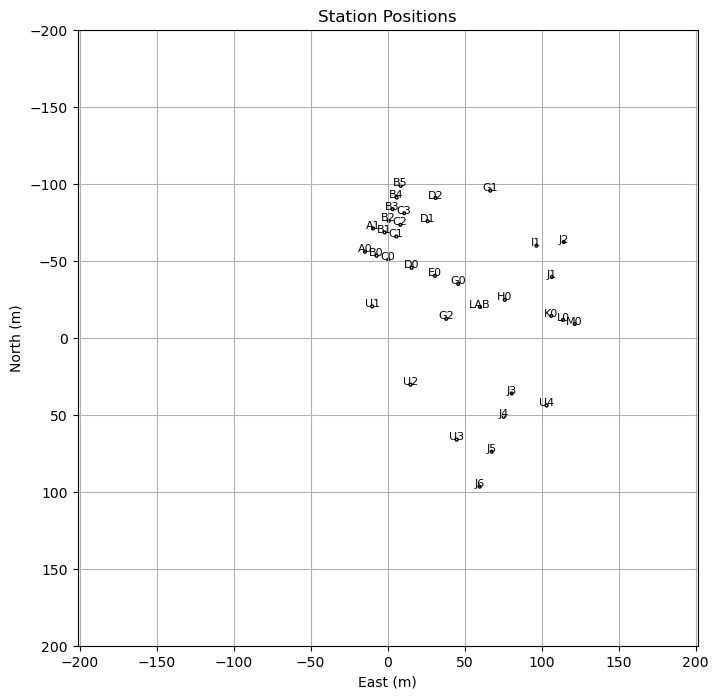

tab: ['2024-11-18T06:52:06.4807', 86.823131, -51.0659, 21701.948]
You observed at 06:52:06.4807 on 2024/11/18
Number of telescopes: 4
Number of baselines: 6
base names: None
st1: [0, 0, 1, 0, 1, 2] st2: [1, 2, 2, 3, 3, 3]
entrée1: U1
entrée2: U2
U1: 92.0, U2: 92.0, Fixed delay: 0.0
U1-U2 // base = 56.57m, angle = 63.98deg
baselines finales: [50.837, 24.812, 0.0]
entrée1: U1
entrée2: U3
U1: 92.0, U3: 99.9738, Fixed delay: 7.973799999999997
U1-U3 // base = 102.43m, angle = 57.63deg
baselines finales: [86.518, 54.84, 0.0]
entrée1: U2
entrée2: U3
U2: 92.0, U3: 99.9738, Fixed delay: 7.973799999999997
U2-U3 // base = 46.63m, angle = 49.92deg
baselines finales: [35.68100000000001, 30.028, 0.0]
entrée1: U1
entrée2: U4
U1: 92.0, U4: 108.0, Fixed delay: 16.0
U1-U4 // base = 130.23m, angle = 29.60deg
baselines finales: [64.334, 113.231, 0.0]
entrée1: U2
entrée2: U4
U2: 92.0, U4: 108.0, Fixed delay: 16.0
U2-U4 // base = 89.44m, angle = 8.68deg
baselines finales: [13.497000000000003, 88.419, 0.0]
e

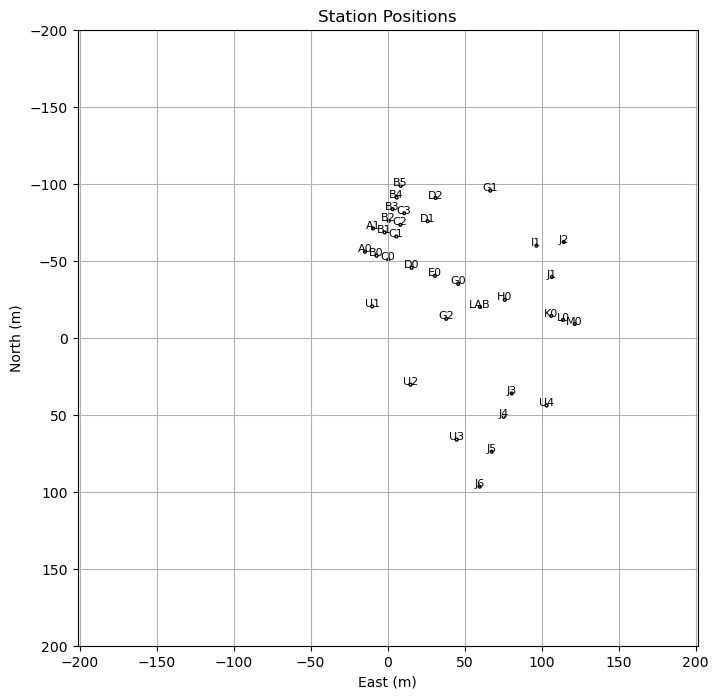

[('A0', -14.642, -55.812), ('A1', -9.434, -70.949), ('B0', -7.065, -53.212), ('B1', -1.863, -68.334), ('B2', 0.739, -75.899), ('B3', 3.348, -83.481), ('B4', 5.945, -91.03), ('B5', 8.547, -98.594), ('C0', 0.487, -50.607), ('C1', 5.691, -65.735), ('C2', 8.296, -73.307), ('C3', 10.896, -80.864), ('D0', 15.628, -45.397), ('D1', 26.039, -75.66), ('D2', 31.243, -90.787), ('E0', 30.76, -40.196), ('G0', 45.896, -34.99), ('G1', 66.716, -95.501), ('G2', 38.063, -12.289), ('H0', 76.15, -24.572), ('I1', 96.711, -59.789), ('J1', 106.648, -39.444), ('J2', 114.46, -62.151), ('J3', 80.628, 36.193), ('J4', 75.424, 51.32), ('J5', 67.618, 74.009), ('J6', 59.81, 96.706), ('K0', 106.397, -14.165), ('L0', 113.977, -11.549), ('M0', 121.535, -8.951), ('U1', -9.925, -20.335), ('U2', 14.887, 30.502), ('U3', 44.915, 66.183), ('U4', 103.306, 43.999), ('LAB', 60.0, -20.0)]
UTs: [[-9.925, -20.335], [14.887, 30.502], [44.915, 66.183], [103.306, 43.999]]
Bx, By: [4.962, 10.166999999999998, 34.989999999999995, 45.8480

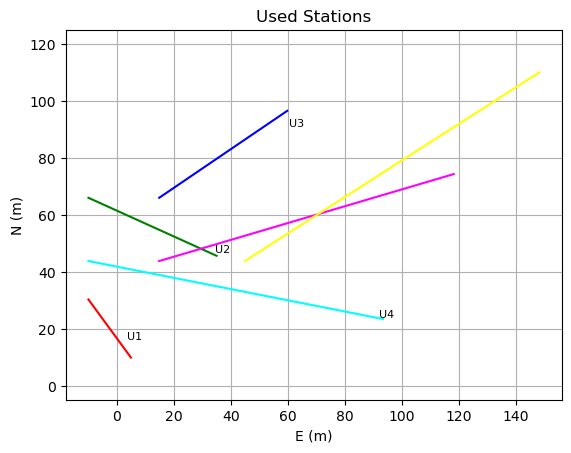

tab: ['2024-11-18T06:52:06.4807', 86.823131, -51.0659, 21701.948]
You observed at 06:52:06.4807 on 2024/11/18
Number of telescopes: 4
Number of baselines: 6
base names: None
st1: [0, 0, 1, 0, 1, 2] st2: [1, 2, 2, 3, 3, 3]
entrée1: U1
entrée2: U2
U1: 92.0, U2: 92.0, Fixed delay: 0.0
U1-U2 // base = 56.57m, angle = 63.98deg
baselines finales: [50.837, 24.812, 0.0]
entrée1: U1
entrée2: U3
U1: 92.0, U3: 99.9738, Fixed delay: 7.973799999999997
U1-U3 // base = 102.43m, angle = 57.63deg
baselines finales: [86.518, 54.84, 0.0]
entrée1: U2
entrée2: U3
U2: 92.0, U3: 99.9738, Fixed delay: 7.973799999999997
U2-U3 // base = 46.63m, angle = 49.92deg
baselines finales: [35.68100000000001, 30.028, 0.0]
entrée1: U1
entrée2: U4
U1: 92.0, U4: 108.0, Fixed delay: 16.0
U1-U4 // base = 130.23m, angle = 29.60deg
baselines finales: [64.334, 113.231, 0.0]
entrée1: U2
entrée2: U4
U2: 92.0, U4: 108.0, Fixed delay: 16.0
U2-U4 // base = 89.44m, angle = 8.68deg
baselines finales: [13.497000000000003, 88.419, 0.0]
e

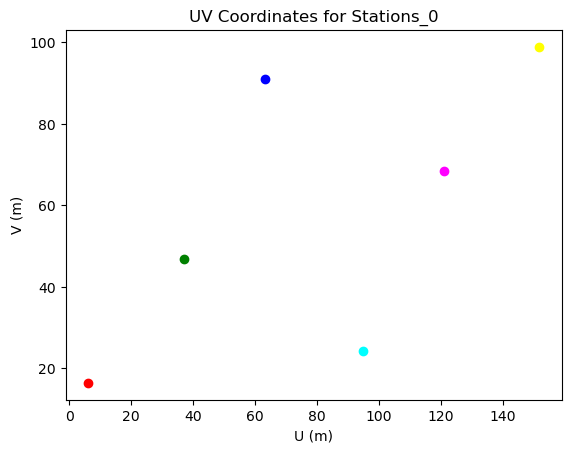

uvw_table: [[[  6.18959337]
  [ 37.09235446]
  [ 63.1861763 ]
  [ 94.7872874 ]
  [120.88110924]
  [151.78387034]]

 [[ 16.4034177 ]
  [ 46.86262465]
  [ 91.13794981]
  [ 24.15960778]
  [ 68.43493295]
  [ 98.8941399 ]]

 [[ 10.48228118]
  [ -6.60779237]
  [-30.247673  ]
  [  0.97551004]
  [-22.66437059]
  [-39.75444414]]]


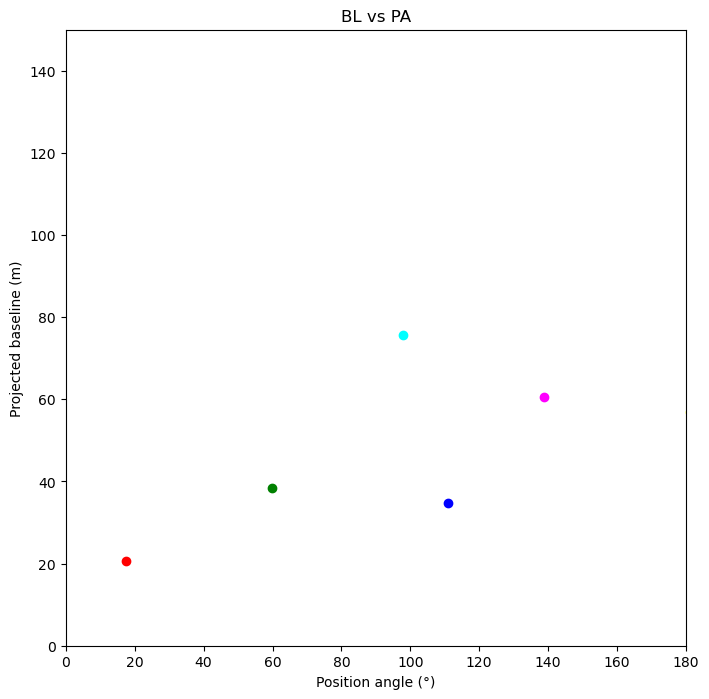

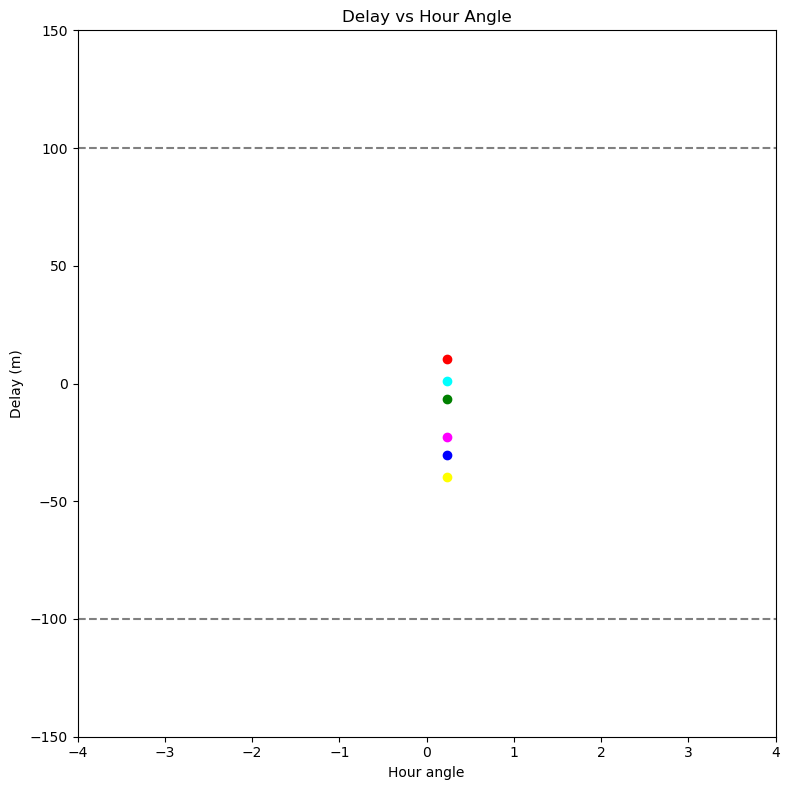

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Set location and initialize
location = simiGetLocation('paranal', 'VLTI')
print('location:', location)
stations = []
stations_files = '/Users/jscigliuto/exoMATISSE/exoMATISSE/simuIterf/info_stations.dat'
stats = simi_save_stations('VLTI', stations_file=stations_files)
n_stats = len([stats])
file_name = '/Users/jscigliuto/exoMATISSE/exoMATISSE/simuIterf/2024-11-18T064409_betPic_U1U2U3U4_IR-LM_MED_IN_OUT_noChop.fits'

dec = 30
stardata = {
    "date": "17/11/2023",
    "ra": 0.0,
    "dec": dec
}

# Configurations
# stations = [
#     ["A1", "B2", "C1"],
#     ["B2", "C1", "D0"],
#     ["A1", "K0", "G1"],
#     ["K0", "G1", "I1"],
#     ["D0", "H0", "G1"],
#     ["D0", "H0", "I1"]
# ]

stations = [
    ['U1', 'U2', 'U3', 'U4']
]

cen = 2.16555e-6
bw = 0.000000086e-6
NN = 2
R = cen / bw * NN
print(f"Resolution: {R}")
lambda_vals = np.linspace(cen - bw / 2, cen + bw / 2, NN)

# Visualization setup
# fig, axes = plt.subplots(2, 2, figsize=(15, 15))
colors = ["red", "green", "blue", "cyan", "magenta", "yellow", "black"]
n_obs = len(stations)
max_base = 150
uv_table_test = None #np.array([[10, -20, 30], [40, -50, 60]])

for k_obs, station_set in enumerate(stations):
    
    # Plot used stations
    # ax1 = axes[0, 0]
    simi_plot_stations(color='black', stations_file=stations_files)
    simi_plot_used_stations_2(uv_table_test, station_set, location, stardata, file_name, stations_files=stations_files, fig_dir=None, color=None, offset=0, line_type='-', no_title=False, no_labels=False)
    # ax1.set_title(f"Used Stations: {', '.join(station_set)}")

    # Plot UV coverage
    # ax2 = axes[0, 1]
    xy_titles = ["E <------ Proj. baseline (m)", "Proj. baseline (m) ------> N"]
    flag, uvw_table, stardata = simi_plot_uv_coordinates(uv_table_test, location, stardata, station_set, file_name, name_string=f"Stations_{k_obs}")

    print('uvw_table:', uvw_table)
    
    # ax2.set_title("UV Coverage")
    # Plot BL vs PA
    fig, ax3 = plt.subplots(1,1, figsize=(8, 8))
    u = uvw_table[0]
    v = uvw_table[1]
    bl = np.sqrt(u**2 + v**2)
    pa = np.degrees(np.arctan2(u, v))

    for i_base in range(len(bl)):
        ax3.plot(bl[i_base], pa[i_base], color=colors[i_base % len(colors)], marker='o')
    ax3.set_xlim(0, 180)
    ax3.set_ylim(0, max_base)
    ax3.set_xlabel("Position angle (°)")
    ax3.set_ylabel("Projected baseline (m)")
    ax3.set_title("BL vs PA")

    # Graphique Delay
    fig, ax4 = plt.subplots(1,1, figsize=(8, 8))
    w = uvw_table[2]
    hour_angle = stardata['ha']  # HA = LST - RA
    for i_base in range(len(w)):
        ax4.plot(hour_angle, w[i_base], color=colors[i_base % len(colors)], marker='o')
    ax4.set_xlim(-4, 4)
    ax4.set_ylim(-max_base, max_base)
    ax4.set_xlabel("Hour angle")
    ax4.set_ylabel("Delay (m)")
    ax4.set_title("Delay vs Hour Angle")
    ax4.axhline(100, color="gray", linestyle="dashed")
    ax4.axhline(-100, color="gray", linestyle="dashed")

plt.tight_layout()
plt.show()